This worksheet is to take the basic random forest benchmark work from Part 1 and add break out some additional featues to see if they improve the score.  

# Data Preprocessing

First I've imported all of fastai which includes pandas and numpy. Then I'll import some of the other functionality I'll need. Next I uploaded the train and test csv files as dataframes and then show their heads just to see what the columns contain. 

In [1]:
from fastai.imports import *

from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


Below I wanted to see the characteristics of both the continuous and the categorical data. From the competition description RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck are the amounts the passenger has billed at each of the Spaceship Titanic's many luxury amenities. Age has much smaller values than the other continuous values and I may want to look at evening these out in the future. 

In the categorical data there are a small number of categories for HomePlanet, CryoSleep, Destination and VIP. 

In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
train.describe(include=object)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


It's interesting that most of the columns have between 179 and 217 missing data fields. Almost all the columns have missing data and the range is very tight. However out of 8693 rows this missing data amounts to only about 2% of the total rows. But the random forest model will need to multiply a coefficient by each value. This can't be done for the missing values. So I'll need to replace the missing values with a number. The easiest way to do this is to replace them with the mode of a column. The mode is the number that occurs most often in a set of values.

In [7]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
modes = train.mode().iloc[0]
modes

PassengerId                0001_01
HomePlanet                   Earth
CryoSleep                    False
Cabin                      G/734/S
Destination            TRAPPIST-1e
Age                           24.0
VIP                          False
RoomService                    0.0
FoodCourt                      0.0
ShoppingMall                   0.0
Spa                            0.0
VRDeck                         0.0
Name            Alraium Disivering
Transported                   True
Name: 0, dtype: object

Below the function will fill all the NaaNs with the modes identified above. Inplace=True simply means that this will be done in the current dataframe and won't need to create a new dataframe.

In [9]:
train.fillna(modes, inplace=True)

In [10]:
train.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

I'll need to do the same thing with the test dataframe. 

In [11]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [12]:
modes = test.mode().iloc[0]
modes

PassengerId              0013_01
HomePlanet                 Earth
CryoSleep                  False
Cabin                    G/160/P
Destination          TRAPPIST-1e
Age                         18.0
VIP                        False
RoomService                  0.0
FoodCourt                    0.0
ShoppingMall                 0.0
Spa                          0.0
VRDeck                       0.0
Name            Berta Barnolderg
Name: 0, dtype: object

In [13]:
test.fillna(modes, inplace=True)

In [14]:
test.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

I want to add new columns for the group and size subcomponents in PassengerId, two new columns to separate out the deck and the side of the Cabin, a new columnn for last name, and a new column to sum up all the spending for the RoomService, FoodCourt, ShoppingMall, Spa and VRDeck columns.

In [15]:
train['Group'] = train['PassengerId'].str[0:4]
train[['Deck', 'Number', 'Side']] = train['Cabin'].str.split('/', expand=True)
splitted = train['Name'].str.split()
train['LastName'] = splitted.str[-1]
train['Spend'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']

In [16]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Number,Side,LastName,Spend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,0,P,Ofracculy,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,0,S,Vines,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,0,S,Susent,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,0,S,Susent,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,1,S,Santantines,1091.0


In [17]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Spend
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.728517,220.009318,448.434027,169.572300,304.588865,298.261820,1440.866329
std,14.355438,660.519050,1595.790627,598.007164,1125.562559,1134.126417,2803.045694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000,1441.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


I also want to do the same things on the test dataset

In [18]:
test['Group'] = test['PassengerId'].str[0:4]
test[['Deck', 'Number', 'Side']] = test['Cabin'].str.split('/', expand=True)
splitted = test['Name'].str.split()
test['LastName'] = splitted.str[-1]
test['Spend'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

In [19]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Deck,Number,Side,LastName,Spend
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,G,3,S,Carsoning,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,F,4,S,Peckers,2832.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,C,0,S,Unhearfus,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,C,1,S,Caltilter,7418.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,F,5,S,Harperez,645.0


I want to do the easiest separation of continuous and categorical variables possible, so I'm using cont_cat_split. 

In [20]:
cont,cat = cont_cat_split(train)

We can see that now the continuous and categorical columns are identified. 

In [21]:
cont

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Spend']

In [22]:
cat

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name',
 'Transported',
 'Group',
 'Deck',
 'Number',
 'Side',
 'LastName']

In [23]:
train[cat]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported,Group,Deck,Number,Side,LastName
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False,0001,B,0,P,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True,0002,F,0,S,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False,0003,A,0,S,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False,0003,A,0,S,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True,0004,F,1,S,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,True,Gravior Noxnuther,False,9276,A,98,P,Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,False,Kurta Mondalley,False,9278,G,1499,S,Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,False,Fayey Connon,True,9279,G,1500,S,Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,False,Celeon Hontichre,False,9280,E,608,S,Hontichre


To create a passengerid dataframe to put PassengerId back into the dataframe after running the model. 

In [24]:
passengerid = pd.DataFrame(test['PassengerId'])

In [25]:
passengerid.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


Then I move through each of the categorical items and transform it into numbers using pd.Categorical. 

In [27]:
for column in cat:
     train[column] = pd.factorize(train[column])[0]

In [24]:
#for i in cat:
#    train[i] = pd.Categorical(train[i])

Each item appears to be still a text item. 

In [28]:
train[cat].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported,Group,Deck,Number,Side,LastName
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,1,1,1,1,0,1,1
2,2,0,0,2,0,1,2,0,2,2,0,1,2
3,3,0,0,2,0,0,3,0,2,2,0,1,2
4,4,1,0,3,0,0,4,1,3,1,1,1,3


Next I break out the categorical data as test_cat and the continuous data as test_cont. Then I convert each column in test_cat into continuous data, since the ML model can only work with numbers. 

In [29]:
test_cont,test_cat = cont_cat_split(test)

In [31]:
for column in test_cat:
     test[column] = pd.factorize(test[column])[0]

Again, the categorical data appears to still be categorical, but behind the scenes they are encoded into categorical data. 

In [32]:
test[test_cat].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Group,Deck,Number,Side,LastName
0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,0,1,1,1,1,0,1
2,2,1,0,2,1,0,2,2,2,2,0,2
3,3,1,1,3,0,0,3,3,2,3,0,3
4,4,0,1,4,0,0,4,4,1,4,0,4


To set up the independent and dependent variables. 

In [33]:
X = train.drop('Transported',axis=1)
y = train.Transported

# Utilizing the Model

I'll need to split the test dataset between the training and validation sections, with 25% being the percent allocated to validation. 

In [34]:
from numpy import random
from sklearn.model_selection import train_test_split

In [35]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=.25, random_state=42)

Finally, I import and run a basic random forest model on the data. The number of estimators is 100 and the minimum number of samples to split a node is at 5. I tried slightly higher and lower numbers for the samples and they came out worse. 

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [37]:
rf = RandomForestClassifier(100, min_samples_leaf=5)

In [38]:
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
accuracy_score(y_test, rf_predictions)

0.7930082796688133

The baseline score is 0.79209. The score with revising the transfer the categorical values to numbers improved to 0.79301.

One nice thing about random forests is that they can give you which variable has the biggest impact. This shows a number of the categories had a stronger impact. 

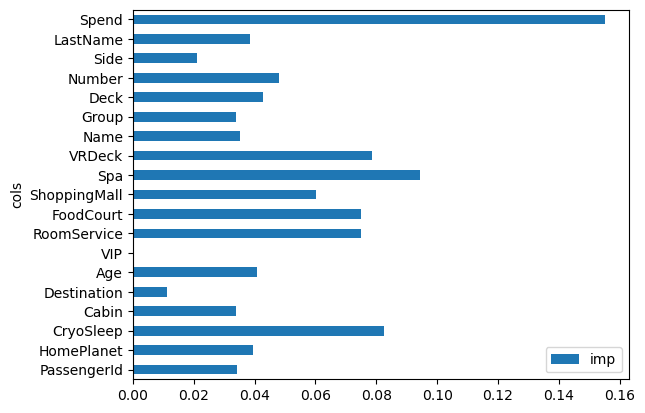

In [40]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf.feature_importances_)).plot('cols', 'imp', 'barh');

# Create Submission File

To run the model on the test file to create the actual predictions. 

In [41]:
test['Transported'] = rf.predict(test)

To add back the PassengerId column and then change the Transported column back to boolean values. 

In [42]:
test['PassengerId'] = passengerid.values

In [44]:
test['Transported'] = np.where(test['Transported'] == 1, 'True', 'False')

In [45]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Deck,Number,Side,LastName,Spend,Transported
0,0013_01,0,0,0,0,27.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,True
1,0018_01,0,1,1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,1,1,1,1,0,1,2832.0,False
2,0019_01,1,0,2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,2,2,2,2,0,2,0.0,True
3,0021_01,1,1,3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,3,3,2,3,0,3,7418.0,True
4,0023_01,0,1,4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,4,4,1,4,0,4,645.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,0,0,3261,0,34.0,0,0.0,0.0,0.0,0.0,0.0,4171,3058,0,1173,0,616,0.0,True
4273,9269_01,0,1,15,0,42.0,0,0.0,847.0,17.0,10.0,144.0,4172,3059,0,9,1,309,1018.0,True
4274,9271_01,2,0,3262,1,18.0,0,0.0,0.0,0.0,0.0,0.0,4173,3060,4,241,1,795,0.0,False
4275,9273_01,1,1,3263,0,18.0,0,0.0,2680.0,0.0,0.0,523.0,4174,3061,4,242,1,482,3203.0,True


This creates the actual submission file with this initial benchmark random forest model. 

In [46]:
submit_file = test[['PassengerId', 'Transported']]

In [47]:
submit_file.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [48]:
submit_file.to_csv('submit_simple_rf_cat-numbers.csv', index=False)

But I only received a Kaggle score of 0.74257, which was way worse than before. 